In [1]:
import io

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

from denseclus import DenseClus

SEED = 42  # random seed to set reproducibility as best we can

sns.set_style("darkgrid")
sns.set_context("notebook")

%matplotlib inline

### Data
Let's start by downloading publicly available Census Income dataset available at https://archive.ics.uci.edu/ml/datasets/Adult. In this dataset we have different attributes such as age, work class, education, country, race etc for each person. We also have an indicator of person's income being more than $50K a year. The prediction task is to determine whether a person makes over 50K a year.


## Data Description
Let's talk about the data. At a high level, we can see:

- There are 15 columns and around 32K rows in the training data
- IncomeGroup is the target field

Specifics on the features:

- 9 of the 14 features are categorical and remaining 5 are numeric

Target variable:
- IncomeGroup_>50K: Whether or not annual income was more than 50K

Now lets read this into a Pandas data frame and take a look.

In [2]:
s3 = boto3.client("s3")
region = boto3.session.Session().region_name

## read the data
s3.download_file(
    f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data", "adult.data"
)
df = pd.read_csv("adult.data", header=None)

## set column names
df.columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "IncomeGroup",
]

df[df["native-country"] == " United-States"]
df.drop(["native-country"], axis=1, inplace=True)

In [3]:
df.describe(include="object")

,workclass,education,marital-status,occupation,relationship,race,sex,IncomeGroup
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,24720


As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting a groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

In [4]:
def fit_denseclus(data, umap_combine_method):
    hdbscan_params = {"cluster_selection_method": "leaf"}

    clf = DenseClus(
        random_state=SEED,
        umap_combine_method=umap_combine_method,
        hdbscan_params=hdbscan_params,
    )
    clf.fit(data)

    return clf

In [13]:
methods = ["intersection", "union", "contrast", "intersection_union_mapper", "ensemble"]

Running method using: intersection
Cluster Coverage without Noise 0.9998157304751083
Calinski-Harabasz Score: 19313.147864255145
Davies-Bouldin Score: 0.583491037517741
------------------------------
Running method using: intersection_union_mapper
Cluster Coverage without Noise 0.9953625502902245
Calinski-Harabasz Score: 185057.98057362591
Davies-Bouldin Score: 1.2701712329122228
------------------------------


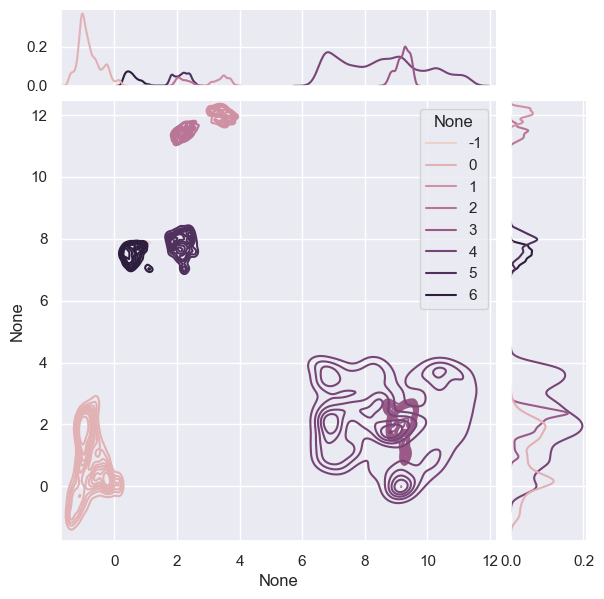

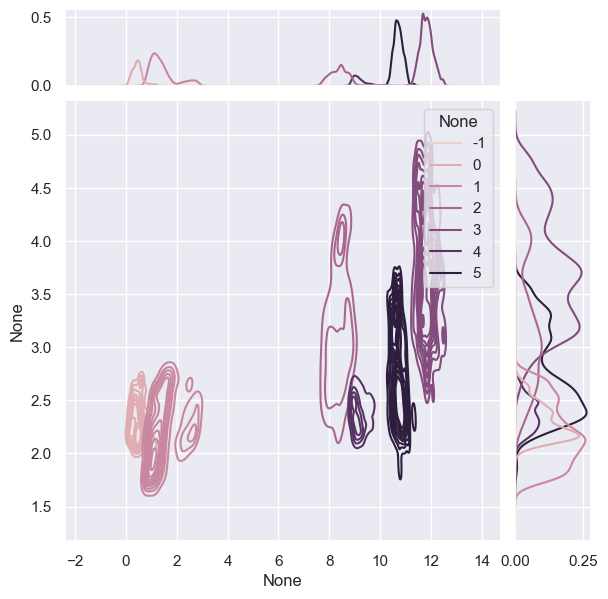

In [18]:
hdbscan_params = {
    "min_cluster_size": 200,
    "min_samples": 30,
    "gen_min_span_tree": True,
    "metric": "manhattan",
    "cluster_selection_method": "eom",
}

for method in methods:
    print(f"Running method using: {method}")
    clf = DenseClus(random_state=SEED, umap_combine_method=method, hdbscan_params=hdbscan_params)
    clf.fit(df)
    clusters = clf.labels_
    clusterd_results = clusters >= 0

    if hasattr(clf, "mapper_"):
        embeddings = clf.mapper_.embedding_
    else:
        embeddings = clf.numerical_umap_.embedding_

    joint_plot = sns.jointplot(
        x=embeddings[:, 0], y=embeddings[:, -1], hue=clusters, kind="kde", marginal_ticks=True
    )

    embedding_len = clf.mapper_.embedding_.shape[0]
    coverage = np.sum(clusterd_results) / embedding_len
    calinski_harabasz = calinski_harabasz_score(embeddings, clusters)
    davies_bouldin = davies_bouldin_score(embeddings, clusters)

    print(f"Cluster Coverage without Noise {coverage}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    print(f"Davies-Bouldin Score: {davies_bouldin}")

    print("-" * 30)